# Sentimental Stocks

In [339]:
%matplotlib inline

# Data Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Helper Libraries
import re
import nltk
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer, PunktSentenceTokenizer, WordPunctTokenizer

# APIs
!pip install yfinance
import yfinance as yf

# ML Libraries
from sklearn.tree import export_text
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Configurations
tqdm.pandas()
pd.options.mode.chained_assignment = None


In [340]:
# Select Stocks
stocks = {
    "TSLA": [1, "Tesla"],
    "HD"  : [2, "Home Depot"],
    "BABA": [3, "Alibaba Group"],
    "NVDA": [4, "NVIDIA Corporation"],
    "JNJ" : [5, "Johnson & Johnson"],
    "NKE" : [6, "Nike"],
    "TWTR": [7, "Twitter Inc."],
    "AAPL": [8, "Apple"],
    "AMZN": [9, "Amazon"],
    "XOM" : [10, "Exxon Mobil"],
    "JPM" : [11, "JP Morgan Chase"],
    "AMC" : [12, "AMC Entertainment"],
    "PLUG": [13, "Plug Power"],
    "PG"  : [14, "Procter & Gamble"],
    "PFE" : [15, "Pfizer"]
}

#----------------------

# Period Selection
sdate_str = '2019-01-01'
edate_str = '2021-12-01'

lagged_sdate_str = '2018-12-01'
lagged_edate_str = '2021-12-15'

sdate_dt = datetime.datetime.strptime(sdate_str, '%Y-%m-%d')
edate_dt = datetime.datetime.strptime(edate_str, '%Y-%m-%d')

# Market Working Days and Holidays
date_range = pd.date_range(sdate_dt, edate_dt - datetime.timedelta(days=1), freq='d')
bdate_range = pd.bdate_range(sdate_dt, edate_dt - datetime.timedelta(days=1))
weekends_dt = [c for c in date_range.difference(bdate_range)]

holidays_str = ['2019-01-01','2019-01-21','2019-02-18','2019-04-19','2019-05-27','2019-07-04','2019-09-02','2019-11-28','2019-12-25',
    '2020-01-01','2020-01-20','2020-02-17','2020-04-10','2020-05-25','2020-07-03','2020-09-07','2020-11-26','2020-12-25',
    '2021-01-01','2021-01-18','2021-02-15','2021-04-02','2021-05-31','2021-07-05','2021-09-06','2021-11-25']
holidays_dt = [datetime.datetime.strptime(c, '%Y-%m-%d') for c in holidays_str]

nonWorkingDays = weekends_dt + holidays_dt
nonWorkingDays.sort()
workingDays = [day for day in date_range if day not in nonWorkingDays]

#----------------------

# Mapping Non-Working Days to Working Days
method = 1 
mapNonWork = {}

for d in nonWorkingDays:

    if method == 1:
        availableDates = [date for date in workingDays if date > d]
    else:
        availableDates = [date for date in workingDays if date < d]

    try:
        mapNonWork[d.strftime('%Y-%m-%d')] = min(availableDates, key=lambda x : abs(x - d)).strftime('%Y-%m-%d')
    except ValueError:
        continue

print(mapNonWork)


{'2019-01-01': '2019-01-02', '2019-01-05': '2019-01-07', '2019-01-06': '2019-01-07', '2019-01-12': '2019-01-14', '2019-01-13': '2019-01-14', '2019-01-19': '2019-01-22', '2019-01-20': '2019-01-22', '2019-01-21': '2019-01-22', '2019-01-26': '2019-01-28', '2019-01-27': '2019-01-28', '2019-02-02': '2019-02-04', '2019-02-03': '2019-02-04', '2019-02-09': '2019-02-11', '2019-02-10': '2019-02-11', '2019-02-16': '2019-02-19', '2019-02-17': '2019-02-19', '2019-02-18': '2019-02-19', '2019-02-23': '2019-02-25', '2019-02-24': '2019-02-25', '2019-03-02': '2019-03-04', '2019-03-03': '2019-03-04', '2019-03-09': '2019-03-11', '2019-03-10': '2019-03-11', '2019-03-16': '2019-03-18', '2019-03-17': '2019-03-18', '2019-03-23': '2019-03-25', '2019-03-24': '2019-03-25', '2019-03-30': '2019-04-01', '2019-03-31': '2019-04-01', '2019-04-06': '2019-04-08', '2019-04-07': '2019-04-08', '2019-04-13': '2019-04-15', '2019-04-14': '2019-04-15', '2019-04-19': '2019-04-22', '2019-04-20': '2019-04-22', '2019-04-21': '2019

# Quantitative Data

In [ ]:
# Stock Prices Data

price_data = {3:[], 7:[], 15:[]}

for stock in tqdm(stocks.keys()):

    # Using Yahoo Finance API
    ticker = yf.Ticker(stock)
    historical_data = ticker.history(start=lagged_sdate_str, end=lagged_edate_str)

    historical_data['Stock'] = stock
    historical_data['Date'] = historical_data.index

    historical_data.sort_index()
    historical_data = historical_data[['Date', 'Stock', 'Open', 'Close']]

    for lag in price_data.keys():

      tempLag_df = historical_data.copy(deep=True)
      tempLag_df['Open'] = tempLag_df['Open'].shift(lag) 

      tempLag_df = tempLag_df[sdate_str:edate_str]
      missing_dates = [date for date in date_range.difference(tempLag_df.index) if date not in nonWorkingDays]

      try:
        assert len(missing_dates) == 0
      except AssertionError:
        print(f'{stock}: {missing_dates}')
        continue
      
      tempLag_df.reset_index(drop=True, inplace=True)
      price_data[lag].append(tempLag_df)

price_data_3 = pd.concat(price_data[3], ignore_index=True)
price_data_7 = pd.concat(price_data[7], ignore_index=True)
price_data_15 = pd.concat(price_data[15], ignore_index=True)


In [ ]:
# Loading and Lagging Price Signals

signals_data = {3:[], 7:[], 15:[]}

price_signals = pd.read_csv('price_signals.csv', converters={'Date': lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')})
price_signals.rename(columns={'ticker':'Stock', 'date':'Date'}, inplace=True)

for stock in tqdm(stocks.keys()):

  temp_df = price_signals.loc[price_signals.Stock == stock].copy(deep=True)
  temp_df.sort_values(by=['Date'], inplace=True, ignore_index=True)
  temp_df = temp_df[['Date', 'Stock', 'EMA', 'MACD_EMA', 'REL_VOL']]

  for lag in signals_data.keys():

    tempLag_df = temp_df.copy(deep=True)
    tempLag_df['Date'] = tempLag_df['Date'].shift(-lag)

    tempLag_df.dropna(subset=['Date'], inplace=True)
    tempLag_df['Date'] = tempLag_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    signals_data[lag].append(tempLag_df)

price_signals_3 = pd.concat(signals_data[3], ignore_index=True)
price_signals_7 = pd.concat(signals_data[3], ignore_index=True)
price_signals_15 = pd.concat(signals_data[3], ignore_index=True)


In [362]:
# Loading and Lagging Financial Fundamentals

fundamentals_data = {3:[], 7:[], 15:[]}

financial_fundamentals = pd.read_csv('financial_signals.csv', converters={'dateEnding': lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')})

for stock in tqdm(stocks.keys()):

  temp_df = financial_fundamentals.loc[financial_fundamentals.ticker == stock].copy(deep=True)
  temp_df.sort_values(by=['dateEnding'], inplace=True, ignore_index=True)
  temp_df.rename(columns={'ticker':'Stock', 'NET_PROFIT_MARGIN': 'NPM', 'dateEnding':'Date'}, inplace=True)
  temp_df = temp_df[['Date', 'Stock', 'SALES_GROWTH', 'NPM']]

  for lag in fundamentals_data.keys():

    tempLag_df = temp_df.copy(deep=True)
    tempLag_df['Date'] = tempLag_df['Date'].shift(-lag) 

    fundamentals_data[lag].append(tempLag_df)

financial_fundamentals_3 = pd.concat(fundamentals_data[3], ignore_index=True)
financial_fundamentals_7 = pd.concat(fundamentals_data[7], ignore_index=True)
financial_fundamentals_15 = pd.concat(fundamentals_data[15], ignore_index=True)


100%|██████████| 15/15 [00:00<00:00, 168.33it/s]


In [364]:
# Quantitative Dataset

stock_data_3 = pd.merge(price_data_3, price_signals_3, how='inner', on=['Date', 'Stock'])
stock_data_3 = pd.merge(stock_data_3, financial_fundamentals_3, how='inner', on=['Date', 'Stock'])

stock_data_7 = pd.merge(price_data_7, price_signals_7, how='inner', on=['Date', 'Stock'])
stock_data_7 = pd.merge(stock_data_7, financial_fundamentals_7, how='inner', on=['Date', 'Stock'])

stock_data_15 = pd.merge(price_data_15, price_signals_15, how='inner', on=['Date', 'Stock'])
stock_data_15 = pd.merge(stock_data_15, financial_fundamentals_15, how='inner', on=['Date', 'Stock'])

stock_data_3


,Date,Stock,Open,Close,EMA,MACD_EMA,REL_VOL,SALES_GROWTH,NPM
0,2019-01-02,TSLA,63.967999,62.023998,67.291669,0.047756,0.181420,1.286346,0.045574
1,2019-01-03,TSLA,64.620003,60.071999,67.242367,-0.178024,0.289201,1.197522,0.019374
2,2019-01-04,TSLA,67.557999,63.537998,67.177380,-0.338532,-0.187762,1.197522,0.019374
3,2019-01-07,TSLA,61.220001,66.991997,66.686581,-0.521314,0.388487,1.197522,0.019374
4,2019-01-08,TSLA,61.400002,67.070000,66.056621,-0.738429,-0.118112,1.197522,0.019374
...,...,...,...,...,...,...,...,...,...
11033,2021-11-24,PFE,51.959999,50.889999,47.639799,1.650804,0.110940,1.035943,0.341594
11034,2021-11-26,PFE,50.950001,54.000000,47.978866,1.740655,-0.458273,1.035943,0.341594
11035,2021-11-29,PFE,50.580002,52.400002,48.274212,1.808965,-0.542438,1.035943,0.341594
11036,2021-11-30,PFE,51.180000,53.730000,48.523335,1.853038,-0.833932,1.035943,0.341594


# Qualitative Data

In [ ]:
# Twitter Data

tweets = pd.read_csv('tweets_raw.csv', converters={'Date':lambda x: datetime.datetime.strptime(x[:10], '%Y-%m-%d')})
print(f'Tweets Data: {list(tweets.columns)} -> {tweets.shape}\n')

#----------------------

# Cleaning Tweets

tweetTok = TweetTokenizer()
sentenceTok = PunktSentenceTokenizer()

def cleanPipelineTwitter(s):
    
    try:
        s = BeautifulSoup(s, 'lxml').get_text()
        s = s.decode('utf-8-sig').replace(u'\ufffd', '?')
    except:
        pass

    s = re.sub(r'@[A-Za-z0-9]+|https?://[A-Za-z0-9./]+|\$[A-Za-z]+', '', s)
    # s = re.sub(r'[^a-zA-Z0-9.,$]', ' ', s)
    
    sentences = [sentence.strip('.') for sentence in sentenceTok.tokenize(s)]
    s = ' '.join(sentences).strip()

    words = tweetTok.tokenize(s)
    s = (' '.join(words)).strip()

    if s != '':
        return s
    else:
        return np.NaN

tweets['Cleaned'] = np.NaN
tweets.drop(columns=['Unnamed: 0'], inplace=True)

tweets.Cleaned = tweets.Text.progress_apply(cleanPipelineTwitter)
tweets.dropna(subset=['Cleaned'], inplace=True)

tweets.head()


Tweets Data: ['Unnamed: 0', 'ID', 'Stock', 'Date', 'User_Name', 'User_ID', 'User_Followers', 'User_Verified', 'User_Lists', 'Likes', 'Retweets', 'Replies', 'URL', 'Text'] -> (84896, 14)



 80%|████████  | 67922/84896 [00:44<00:07, 2360.57it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/EByFX8aVh7" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
100%|██████████| 84896/84896 [00:51<00:00, 1635.95it/s]


,ID,Stock,Date,User_Name,User_ID,User_Followers,User_Verified,User_Lists,Likes,Retweets,Replies,URL,Text,Cleaned
0,1410747714854289411,AMC,2021-07-01,𝒪𝓂𝒶𝓇𝒾 𝐹𝒶𝒾𝓉𝒽,3857937862,4942,0,9,883,171,28,https://twitter.com/OmariFaith_/status/1410747...,(Part3) there's so many more signs but these a...,( Part 3 ) there's so many more signs but thes...
1,1410747231137763329,AMC,2021-07-01,Jackson Hunter,408009251,39132,0,185,777,26,61,https://twitter.com/jhuntermav/status/14107472...,I've taken down the Convertible Bonds livestre...,I've taken down the Convertible Bonds livestre...
2,1410740903690477570,AMC,2021-07-01,KONG,1357863450802749440,58536,0,258,861,56,71,https://twitter.com/KongPosting/status/1410740...,"When in the Middle East, I was blindsided by s...","When in the Middle East , I was blindsided by ..."
3,1410739852283236353,AMC,2021-07-01,KONG,1357863450802749440,58536,0,258,508,61,28,https://twitter.com/KongPosting/status/1410739...,MY $AMC POSITIONS?\nLONG.\nMY STROKES? \nLONG....,MY POSITIONS ? LONG MY STROKES ? LONG MY TOLER...
4,1410739197300772869,AMC,2021-07-01,Aviv Hadar ,15900714,8227,0,82,121,20,16,https://twitter.com/avivhadar/status/141073919...,All $AMC shareholders need to watch this video...,All shareholders need to watch this video #AMC...


In [ ]:
# Lagging Tweets

tweets_data = {3:[], 7:[], 15:[]}

for stock in tqdm(stocks.keys()):

  temp_df = tweets.loc[tweets.Stock == stock].copy(deep=True)
  temp_df.sort_values(by=['Date'], inplace=True, ignore_index=True)

  for lag in tweets_data.keys():
    tempLag_df = temp_df.copy(deep=True)
    tempLag_df['Date'] = tempLag_df['Date'].apply(lambda x: x + datetime.timedelta(days=lag)) 

    tweets_data[lag].append(tempLag_df)

tweets_3 = pd.concat(tweets_data[3], ignore_index=True)
tweets_7 = pd.concat(tweets_data[7], ignore_index=True)
tweets_15 = pd.concat(tweets_data[15], ignore_index=True)

#----------------------

# Mapping Non-Working Day tweets to Working Day Tweets

tweets_3['Date'] = tweets_3['Date'].apply(lambda x: mapNonWork[x.strftime('%Y-%m-%d')] if x.strftime('%Y-%m-%d') in mapNonWork else x)
tweets_7['Date'] = tweets_7['Date'].apply(lambda x: mapNonWork[x.strftime('%Y-%m-%d')] if x.strftime('%Y-%m-%d') in mapNonWork else x)
tweets_15['Date'] = tweets_15['Date'].apply(lambda x: mapNonWork[x.strftime('%Y-%m-%d')] if x.strftime('%Y-%m-%d') in mapNonWork else x)

tweets_3


100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


,ID,Stock,Date,User_Name,User_ID,User_Followers,User_Verified,User_Lists,Likes,Retweets,Replies,URL,Text,Cleaned
0,1080099366164201472,TSLA,2019-01-04,TC,962805945020702722,47176,0,740,123,19,17,https://twitter.com/TESLAcharts/status/1080099...,The final numbers are in. The Jaguar I-Pace de...,The final numbers are in The Jaguar I-Pace des...
1,1080159123818205184,TSLA,2019-01-04,Bark 🧦🐶🕺🏼🪑,980554784133427200,4420,0,64,72,10,1,https://twitter.com/BarkMSmeagol/status/108015...,Congrats to everyone at @Tesla for remarkable ...,Congrats to everyone at for remarkable 2018 ! ...
2,1080176804671995908,TSLA,2019-01-04,TC,962805945020702722,47176,0,740,56,20,7,https://twitter.com/TESLAcharts/status/1080176...,"1/ “Tesla sold an epic 22,250 Model 3s in Sep...","1 / “ Tesla sold an epic 22,250 Model 3s in Se..."
3,1080234643473850368,TSLA,2019-01-04,Bark 🧦🐶🕺🏼🪑,980554784133427200,4420,0,64,59,10,5,https://twitter.com/BarkMSmeagol/status/108023...,This poor $TSLAQ soul officially now has the t...,This poor soul officially now has the title of...
4,1080076822048583681,TSLA,2019-01-04,🚀 🐉 Steve Hamel 🐉🚀,999632398525530114,7824,0,75,32,12,4,https://twitter.com/SteveHamel16/status/108007...,1/My goals for Tesla this year\n\n(Multi Part)...,1 / My goals for Tesla this year ( Multi Part ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84214,1465308761481003010,PFE,2021-12-02,Carl Quintanilla,114782468,324886,1,4976,160,33,8,https://twitter.com/carlquintanilla/status/146...,Bourla points out they’ve already done this tw...,Bourla points out they ’ ve already done this ...
84215,1465467867709669377,PFE,2021-12-02,Top Tier Alerts,2525901589,10567,0,59,95,12,6,https://twitter.com/TopTierAlerts/status/14654...,"November 30th, 2021 Watchlist:\n\n$MRNA - Pote...","November 30th , 2021 Watchlist : - Potential U..."
84216,1465414174297710595,PFE,2021-12-02,They're Yellowjackets.,16456226,9486,0,298,59,35,3,https://twitter.com/tickerguy/status/146541417...,"Oh, we have official corruption eh? I hope ev...","Oh , we have official corruption eh ? I hope e..."
84217,1465135446170607617,PFE,2021-12-02,えす🇺🇸米国株,1173944008910880769,24755,0,477,148,19,2,https://twitter.com/Skabutoushi/status/1465135...,オミクロン変異株とワクチンばかり注目されてますが、ウイルスが変異しやすくワクチンが変異しやす...,オミクロン変異株とワクチンばかり注目されてますが 、 ウイルスが変異しやすくワクチンが変異し...


In [ ]:
# Company and Financial News

news = pd.read_csv('news_raw.csv', converters={'Date': lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')})
print(f'News Data: {list(news.columns)} -> {news.shape}')

#----------------------

# Cleaning Title and Description

wordTok = WordPunctTokenizer()

def cleanPipelineNews(s):

    try:
        s = s.decode('utf-8-sig').replace(u'\ufffd', '?')
    except:
        pass
    
    words = wordTok.tokenize(s)
    s = (' '.join(words)).strip()

    if s != '':
        return s
    else:
        return np.NaN

#----------------------

news['Description'] = news.apply(lambda row: row['Title'] if row['Description'] is np.NaN else row['Description'], axis=1)

news['Title_Cleaned'] = news.progress_apply(lambda row: cleanPipelineNews(row['Title']), axis=1)
news['Description_Cleaned'] = news.progress_apply(lambda row: cleanPipelineNews(row['Description']), axis=1)
news.dropna(subset=['Title_Cleaned', 'Description_Cleaned'], inplace=True)

news


News Data: ['ID', 'Stock', 'Date', 'Publisher', 'Title', 'Author', 'Description', 'URL'] -> (34749, 8)


100%|██████████| 34749/34749 [00:01<00:00, 26572.28it/s]


,ID,Stock,Date,Publisher,Title,Author,Description,URL,Title_Cleaned,Description_Cleaned
0,62112651,TSLA,2021-01-02,benzinga,Benzinga's Final Bulls And Bears Of The Year: ...,benzinga,Benzinga has examined the prospects for many i...,https://finnhub.io/api/news?id=06eb69054d00642...,Benzinga ' s Final Bulls And Bears Of The Year...,Benzinga has examined the prospects for many i...
1,62112644,TSLA,2021-01-02,benzinga,Tesla Deliveries Fall Just Short Of Musk's 500...,benzinga,"Tesla Inc delivered 499,550 vehicles in 2020, ...",https://finnhub.io/api/news?id=775391328af7bad...,Tesla Deliveries Fall Just Short Of Musk ' s 5...,"Tesla Inc delivered 499 , 550 vehicles in 2020..."
2,62102066,TSLA,2021-01-01,https://cleantechnica.com,Tesla Hiring Battery Engineers In North Caroli...,https://cleantechnica.com,"Job openings are not product roadmaps, but the...",https://finnhub.io/api/news?id=963902dc23d763b...,Tesla Hiring Battery Engineers In North Caroli...,"Job openings are not product roadmaps , but th..."
3,62097972,TSLA,2021-01-01,MarketWatch,Tesla Cuts Prices In China. That Could Be Bad ...,MarketWatch,Tesla recently posted pricing for its Chinese-...,https://finnhub.io/api/news?id=e1bb5d13caf61eb...,Tesla Cuts Prices In China . That Could Be Bad...,Tesla recently posted pricing for its Chinese ...
4,62098219,TSLA,2021-01-01,MarketWatch,Lidar Is Coming To XPeng as Tesla Holds Out on...,MarketWatch,Chinese electrical vehicle maker XPeng is uppi...,https://finnhub.io/api/news?id=154fdfc38e08086...,Lidar Is Coming To XPeng as Tesla Holds Out on...,Chinese electrical vehicle maker XPeng is uppi...
...,...,...,...,...,...,...,...,...,...,...
34744,bfg1yzV656DXv1IfwU2PWvIeuAlimIEDyIZ8kf6caQY,PFE,2021-11-30,Zacks Investment Research,"Top Research Reports for Mastercard, Pfizer & ...",Mark Vickery,Today's Research Daily features new research r...,https://www.zacks.com/research-daily/1833493/t...,"Top Research Reports for Mastercard , Pfizer &...",Today ' s Research Daily features new research...
34745,dLO0Bp_iMZOVlNhy3_7tpDQpY7aeeOf6Pmt8bYGeOS4,PFE,2021-11-30,MarketWatch,Omicron is bound to disrupt supply chains. The...,MarketWatch,Businesses may be better equipped to deal with...,https://www.marketwatch.com/story/omicron-is-b...,Omicron is bound to disrupt supply chains . Th...,Businesses may be better equipped to deal with...
34746,Kf193G24P9O7ksNKdrIShgXbaHZfqLyHBrAvEnqCZ8c,PFE,2021-11-30,The Motley Fool,Why Novavax and Pfizer Are Trouncing the Marke...,newsfeedback@fool.com (Eric Volkman),But not all coronavirus stocks were on the rise.,https://www.fool.com/investing/2021/11/30/why-...,Why Novavax and Pfizer Are Trouncing the Marke...,But not all coronavirus stocks were on the rise .
34747,H_BjbXKbPhpLt-SsuJKa6hTE8C3nSQApsfRp9n2IaGQ,PFE,2021-11-30,Benzinga,Moderna And Pfizer Share Top Prize In Popular ...,Phil Hall,"Lifesaving vaccines, an anti-tracking software...",https://www.benzinga.com/general/biotech/21/11...,Moderna And Pfizer Share Top Prize In Popular ...,"Lifesaving vaccines , an anti - tracking softw..."


In [ ]:
# Lagging News

news_data = {3:[], 7:[], 15:[]}

for stock in tqdm(stocks.keys()):

  temp_df = news.loc[news.Stock == stock].copy(deep=True)
  temp_df.sort_values(by=['Date'], inplace=True, ignore_index=True)

  for lag in news_data.keys():
    tempLag_df = temp_df.copy(deep=True)
    tempLag_df['Date'] = tempLag_df['Date'].apply(lambda x: x + datetime.timedelta(days=lag))

    news_data[lag].append(tempLag_df)

news_3 = pd.concat(news_data[3], ignore_index=True)
news_7 = pd.concat(news_data[7], ignore_index=True)
news_15 = pd.concat(news_data[15], ignore_index=True)

#----------------------

# Mapping Non-Working Day articles to Working Day articles

news_3['Date'] = news_3['Date'].apply(lambda x: mapNonWork[x.strftime('%Y-%m-%d')] if x.strftime('%Y-%m-%d') in mapNonWork else x)
news_7['Date'] = news_7['Date'].apply(lambda x: mapNonWork[x.strftime('%Y-%m-%d')] if x.strftime('%Y-%m-%d') in mapNonWork else x)
news_15['Date'] = news_15['Date'].apply(lambda x: mapNonWork[x.strftime('%Y-%m-%d')] if x.strftime('%Y-%m-%d') in mapNonWork else x)

news_3


100%|██████████| 15/15 [00:01<00:00, 12.53it/s]


,ID,Stock,Date,Publisher,Title,Author,Description,URL,Title_Cleaned,Description_Cleaned
0,W_9rNK6k-11ExzV5cJG2tiNFDOF8O5hsHoSSJPh2MnM,TSLA,2020-04-06,Zacks Investment Research,Second Quarter Begins with a 4% Plunge,Jim Giaquinto,Second Quarter Begins with a 4% Plunge,https://www.zacks.com/registration/ultimatetra...,Second Quarter Begins with a 4 % Plunge,Second Quarter Begins with a 4 % Plunge
1,75LUnOLFR3KJrPs7DOGM11-IyN-LyKhJMpubDRYSkJE,TSLA,2020-05-05,Zacks Investment Research,Market Slides More Than 2% to Begin May,Jim Giaquinto,Market Slides More Than 2% to Begin May,https://www.zacks.com/registration/ultimatetra...,Market Slides More Than 2 % to Begin May,Market Slides More Than 2 % to Begin May
2,p2jgrnxsSb94MiBbPxm8Dv2qyZDlr6cANZXNkpADuWc,TSLA,2020-05-18,Zacks Investment Research,"Stocks Slide About 2%, Ending NASDAQ's Six-Day...",Jim Giaquinto,"Stocks Slide About 2%, Ending NASDAQ's Six-Day...",https://www.zacks.com/registration/ultimatetra...,"Stocks Slide About 2 %, Ending NASDAQ ' s Six ...","Stocks Slide About 2 %, Ending NASDAQ ' s Six ..."
3,FKbEw5f1vh6229IH7neHf2rCxZTfZZS0MRclvNn14lw,TSLA,2020-06-15,Zacks Investment Research,NASDAQ Finishes Above 10K with Third Straight ...,Jim Giaquinto,NASDAQ Finishes Above 10K with Third Straight ...,https://www.zacks.com/registration/ultimatetra...,NASDAQ Finishes Above 10K with Third Straight ...,NASDAQ Finishes Above 10K with Third Straight ...
4,am06QPReATVh0UF4MgUj6G2S-k-GEs8JeWmb1SHiq3U,TSLA,2020-07-14,Zacks Investment Research,Dow Jumps 1.4% as Stocks Gain for Second Strai...,Jim Giaquinto,Dow Jumps 1.4% as Stocks Gain for Second Strai...,https://www.zacks.com/registration/ultimatetra...,Dow Jumps 1 . 4 % as Stocks Gain for Second St...,Dow Jumps 1 . 4 % as Stocks Gain for Second St...
...,...,...,...,...,...,...,...,...,...,...
34744,75307218,PFE,2021-12-04,Finnhub,Japan begins administering Pfizer booster doses,Finnhub,"Tokyo, Dec 1 .- Japan on Wednesday began to ad...",https://finnhub.io/api/news?id=b946f550f6a801c...,Japan begins administering Pfizer booster doses,"Tokyo , Dec 1 .- Japan on Wednesday began to a..."
34745,75319205,PFE,2021-12-04,Nasdaq,Sanofi to buy Origimm Biotechnology for acne v...,Nasdaq,French healthcare company Sanofi said on Wedne...,https://finnhub.io/api/news?id=6c464f982fe8b1d...,Sanofi to buy Origimm Biotechnology for acne v...,French healthcare company Sanofi said on Wedne...
34746,75215755,PFE,2021-12-04,Yahoo,Dow Jones Futures: Market Rally Skids On This ...,Yahoo,Dow Jones futures: Fed chief Jerome Powell com...,https://finnhub.io/api/news?id=1e064ba22c8a824...,Dow Jones Futures : Market Rally Skids On This...,Dow Jones futures : Fed chief Jerome Powell co...
34747,75346061,PFE,2021-12-04,Nasdaq,Is A Rise Imminent For Merck Stock After An 8%...,Nasdaq,"[Updated: Nov 29, 2021] Merck Covid-19 Pill Up...",https://finnhub.io/api/news?id=cd6c02ff747e854...,Is A Rise Imminent For Merck Stock After An 8 ...,"[ Updated : Nov 29 , 2021 ] Merck Covid - 19 P..."


# Sentiment Analysis

In [ ]:
# Twitter Sentiments

nltk.download('vader_lexicon')
sentiment = SentimentIntensityAnalyzer()

max_followers, max_lists = tweets.User_Followers.max(), tweets.User_Lists.max()

#----------------------

def twitterSentiment(df) -> pd.DataFrame:

    df['sentiment'] = df.progress_apply(lambda row:sentiment.polarity_scores(row['Cleaned'])['compound'], axis=1)
    df['weighted_sentiment'] = df.apply(weightedSentiment, axis=1)
    return df

def weightedSentiment(row) -> float:

    score = row['sentiment']
    score *= row['Retweets'] * row['Replies'] * row['Likes']

    user_verified = {0:1, 1:1.25}
    user_followers = {0:1, 500:1.1, 1000:1.15, 5000:1.2, 10000:1.3, 50000:1.4, 100000:1.5, 200000:1.6, 300000:1.7, 500000:1.8, 1000000:1.9, max_followers:2}
    user_lists = {0:1, 100:1.1, 1000:1.2, 5000:1.3, 10000:1.4, max_lists:1.5}

    user_followers_keys = list(user_followers.keys())
    user_lists_keys = list(user_lists.keys())

    score *= user_verified[row['User_Verified']]
    score *= user_followers[user_followers_keys[min(range(len(user_followers_keys)), key = lambda i: abs(user_followers_keys[i]-row['User_Followers']))]]
    score *= user_lists[user_lists_keys[min(range(len(user_lists_keys)), key = lambda i: abs(user_lists_keys[i]-row['User_Lists']))]]

    return score
  
def matchSentiment(id) -> list:

    row = tweets[tweets['ID']==id]
    return [row.sentiment, row.weighted_sentiment]

#----------------------

tweets = twitterSentiment(tweets)
tweets_sent = tweets[['ID', 'Stock','sentiment','weighted_sentiment']].copy(deep=True)

tweets_3 = pd.merge(tweets_3, tweets_sent, on=['ID', 'Stock'], how='left')
tweets_7 = pd.merge(tweets_7, tweets_sent, on=['ID', 'Stock'], how='left')
tweets_15 = pd.merge(tweets_15, tweets_sent, on=['ID', 'Stock'], how='left')

tweets_3

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|██████████| 84219/84219 [00:33<00:00, 2493.27it/s]


,ID,Stock,Date,User_Name,User_ID,User_Followers,User_Verified,User_Lists,Likes,Retweets,Replies,URL,Text,Cleaned,sentiment,weighted_sentiment
0,1080099366164201472,TSLA,2019-01-04,TC,962805945020702722,47176,0,740,123,19,17,https://twitter.com/TESLAcharts/status/1080099...,The final numbers are in. The Jaguar I-Pace de...,The final numbers are in The Jaguar I-Pace des...,-0.4939,-32965.217208
1,1080159123818205184,TSLA,2019-01-04,Bark 🧦🐶🕺🏼🪑,980554784133427200,4420,0,64,72,10,1,https://twitter.com/BarkMSmeagol/status/108015...,Congrats to everyone at @Tesla for remarkable ...,Congrats to everyone at for remarkable 2018 ! ...,0.8951,850.703040
2,1080176804671995908,TSLA,2019-01-04,TC,962805945020702722,47176,0,740,56,20,7,https://twitter.com/TESLAcharts/status/1080176...,"1/ “Tesla sold an epic 22,250 Model 3s in Sep...","1 / “ Tesla sold an epic 22,250 Model 3s in Se...",-0.2500,-3292.800000
3,1080234643473850368,TSLA,2019-01-04,Bark 🧦🐶🕺🏼🪑,980554784133427200,4420,0,64,59,10,5,https://twitter.com/BarkMSmeagol/status/108023...,This poor $TSLAQ soul officially now has the t...,This poor soul officially now has the title of...,-0.4215,-1641.321000
4,1080076822048583681,TSLA,2019-01-04,🚀 🐉 Steve Hamel 🐉🚀,999632398525530114,7824,0,75,32,12,4,https://twitter.com/SteveHamel16/status/108007...,1/My goals for Tesla this year\n\n(Multi Part)...,1 / My goals for Tesla this year ( Multi Part ...,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84214,1465308761481003010,PFE,2021-12-02,Carl Quintanilla,114782468,324886,1,4976,160,33,8,https://twitter.com/carlquintanilla/status/146...,Bourla points out they’ve already done this tw...,Bourla points out they ’ ve already done this ...,0.0000,0.000000
84215,1465467867709669377,PFE,2021-12-02,Top Tier Alerts,2525901589,10567,0,59,95,12,6,https://twitter.com/TopTierAlerts/status/14654...,"November 30th, 2021 Watchlist:\n\n$MRNA - Pote...","November 30th , 2021 Watchlist : - Potential U...",0.4389,4292.968680
84216,1465414174297710595,PFE,2021-12-02,They're Yellowjackets.,16456226,9486,0,298,59,35,3,https://twitter.com/tickerguy/status/146541417...,"Oh, we have official corruption eh? I hope ev...","Oh , we have official corruption eh ? I hope e...",0.3094,2740.928190
84217,1465135446170607617,PFE,2021-12-02,えす🇺🇸米国株,1173944008910880769,24755,0,477,148,19,2,https://twitter.com/Skabutoushi/status/1465135...,オミクロン変異株とワクチンばかり注目されてますが、ウイルスが変異しやすくワクチンが変異しやす...,オミクロン変異株とワクチンばかり注目されてますが 、 ウイルスが変異しやすくワクチンが変異し...,0.0000,0.000000


In [ ]:
# News Sentiments

def newsSentiment(df) -> pd.DataFrame:

    df['compound_t'] = df.progress_apply(lambda row:sentiment.polarity_scores(row['Title_Cleaned'])['compound'], axis=1)
    df['compound_d'] = df.progress_apply(lambda row:sentiment.polarity_scores(row['Description_Cleaned'])['compound'], axis=1)
    
    df['sentiment'] = df.apply(avgSentiment, axis=1)
    df.drop(columns=['compound_t','compound_d'], inplace=True)
    print('')
    return df

def avgSentiment(row):

    compound = (row['compound_t'] + row['compound_d']) / 2
    return compound

#----------------------

news_3 = newsSentiment(news_3)
news_7 = newsSentiment(news_7)
news_15 = newsSentiment(news_15)

news_3


100%|██████████| 34749/34749 [00:24<00:00, 1415.90it/s]


100%|██████████| 34749/34749 [00:23<00:00, 1464.01it/s]


100%|██████████| 34749/34749 [00:23<00:00, 1464.06it/s]


,ID,Stock,Date,Publisher,Title,Author,Description,URL,Title_Cleaned,Description_Cleaned,sentiment
0,W_9rNK6k-11ExzV5cJG2tiNFDOF8O5hsHoSSJPh2MnM,TSLA,2020-04-06,Zacks Investment Research,Second Quarter Begins with a 4% Plunge,Jim Giaquinto,Second Quarter Begins with a 4% Plunge,https://www.zacks.com/registration/ultimatetra...,Second Quarter Begins with a 4 % Plunge,Second Quarter Begins with a 4 % Plunge,0.00000
1,75LUnOLFR3KJrPs7DOGM11-IyN-LyKhJMpubDRYSkJE,TSLA,2020-05-05,Zacks Investment Research,Market Slides More Than 2% to Begin May,Jim Giaquinto,Market Slides More Than 2% to Begin May,https://www.zacks.com/registration/ultimatetra...,Market Slides More Than 2 % to Begin May,Market Slides More Than 2 % to Begin May,0.00000
2,p2jgrnxsSb94MiBbPxm8Dv2qyZDlr6cANZXNkpADuWc,TSLA,2020-05-18,Zacks Investment Research,"Stocks Slide About 2%, Ending NASDAQ's Six-Day...",Jim Giaquinto,"Stocks Slide About 2%, Ending NASDAQ's Six-Day...",https://www.zacks.com/registration/ultimatetra...,"Stocks Slide About 2 %, Ending NASDAQ ' s Six ...","Stocks Slide About 2 %, Ending NASDAQ ' s Six ...",0.00000
3,FKbEw5f1vh6229IH7neHf2rCxZTfZZS0MRclvNn14lw,TSLA,2020-06-15,Zacks Investment Research,NASDAQ Finishes Above 10K with Third Straight ...,Jim Giaquinto,NASDAQ Finishes Above 10K with Third Straight ...,https://www.zacks.com/registration/ultimatetra...,NASDAQ Finishes Above 10K with Third Straight ...,NASDAQ Finishes Above 10K with Third Straight ...,0.22630
4,am06QPReATVh0UF4MgUj6G2S-k-GEs8JeWmb1SHiq3U,TSLA,2020-07-14,Zacks Investment Research,Dow Jumps 1.4% as Stocks Gain for Second Strai...,Jim Giaquinto,Dow Jumps 1.4% as Stocks Gain for Second Strai...,https://www.zacks.com/registration/ultimatetra...,Dow Jumps 1 . 4 % as Stocks Gain for Second St...,Dow Jumps 1 . 4 % as Stocks Gain for Second St...,0.64860
...,...,...,...,...,...,...,...,...,...,...,...
34744,75307218,PFE,2021-12-04,Finnhub,Japan begins administering Pfizer booster doses,Finnhub,"Tokyo, Dec 1 .- Japan on Wednesday began to ad...",https://finnhub.io/api/news?id=b946f550f6a801c...,Japan begins administering Pfizer booster doses,"Tokyo , Dec 1 .- Japan on Wednesday began to a...",0.00000
34745,75319205,PFE,2021-12-04,Nasdaq,Sanofi to buy Origimm Biotechnology for acne v...,Nasdaq,French healthcare company Sanofi said on Wedne...,https://finnhub.io/api/news?id=6c464f982fe8b1d...,Sanofi to buy Origimm Biotechnology for acne v...,French healthcare company Sanofi said on Wedne...,0.20095
34746,75215755,PFE,2021-12-04,Yahoo,Dow Jones Futures: Market Rally Skids On This ...,Yahoo,Dow Jones futures: Fed chief Jerome Powell com...,https://finnhub.io/api/news?id=1e064ba22c8a824...,Dow Jones Futures : Market Rally Skids On This...,Dow Jones futures : Fed chief Jerome Powell co...,-0.42150
34747,75346061,PFE,2021-12-04,Nasdaq,Is A Rise Imminent For Merck Stock After An 8%...,Nasdaq,"[Updated: Nov 29, 2021] Merck Covid-19 Pill Up...",https://finnhub.io/api/news?id=cd6c02ff747e854...,Is A Rise Imminent For Merck Stock After An 8 ...,"[ Updated : Nov 29 , 2021 ] Merck Covid - 19 P...",0.00000


# Final Dataset

In [365]:
# Merging Operations

lags = {3:[stock_data_3, tweets_3, news_3], 7:[stock_data_7, tweets_7, news_7], 15:[stock_data_15, tweets_15, news_15]}

for lag, dfPointers in lags.items():

  stock_data_i = dfPointers[0]
  tweets_i = dfPointers[1]
  news_i = dfPointers[2]

  df = stock_data_i.copy(deep=True)
  df['tweets_SentMean'] = 0.0
  df['tweets_WeightedSentMean'] = 0.0
  df['news_SentMean'] = 0.0

  #----------------------

  for idx, row in tqdm(stock_data_i.iterrows(), total=len(stock_data_i.index)):

      stock = row['Stock']
      date = row['Date']

      tweets_select = tweets_i.loc[(tweets_i.Stock == stock) & (tweets_i.Date == date)]
      news_select = news_i.loc[(news_i.Stock == stock) & (news_i.Date == date)]
      
      if len(tweets_select.index) > 0:
          tweets_select = tweets_select[['sentiment','weighted_sentiment']]
          sentiment_mean = tweets_select['sentiment'].mean()
          weighted_sentiment_mean = tweets_select['weighted_sentiment'].mean()

          df.at[idx, 'tweets_SentMean'] = sentiment_mean
          df.at[idx, 'tweets_WeightedSentMean'] = weighted_sentiment_mean

      if len(news_select.index) > 0:
          sentiment_mean = news_select['sentiment'].mean()

          df.at[idx, 'news_SentMean'] = sentiment_mean
      
  #----------------------

  df.to_csv(f'ml_dataset_{lag}.csv', index=False)
  print(f'Final Data Lag {lag}: {list(df.columns)} -> {df.shape}\n')

  df.head(5)


100%|██████████| 11038/11038 [01:46<00:00, 103.45it/s]


Final Data Lag 3: ['Date', 'Stock', 'Open', 'Close', 'EMA', 'MACD_EMA', 'REL_VOL', 'SALES_GROWTH', 'NPM', 'tweets_SentMean', 'tweets_WeightedSentMean', 'news_SentMean'] -> (11038, 12)



100%|██████████| 11038/11038 [01:45<00:00, 104.55it/s]


Final Data Lag 7: ['Date', 'Stock', 'Open', 'Close', 'EMA', 'MACD_EMA', 'REL_VOL', 'SALES_GROWTH', 'NPM', 'tweets_SentMean', 'tweets_WeightedSentMean', 'news_SentMean'] -> (11038, 12)



100%|██████████| 11038/11038 [01:45<00:00, 105.07it/s]


Final Data Lag 15: ['Date', 'Stock', 'Open', 'Close', 'EMA', 'MACD_EMA', 'REL_VOL', 'SALES_GROWTH', 'NPM', 'tweets_SentMean', 'tweets_WeightedSentMean', 'news_SentMean'] -> (11038, 12)



# Linear Regression

In [393]:
# Data Prep (Linear Regression)

select_lag = 15
df = pd.read_csv(f'ml_dataset_{select_lag}.csv')

df['Stock_Num'] = df['Stock'].apply(lambda x: stocks[x][0])
df.drop(columns=['Stock'], inplace=True)

df['Date'] = pd.to_datetime(df['Date'])  
date_series = df['Date']
df['Date']=df['Date'].map(datetime.datetime.toordinal)

df.sort_values(['Stock_Num', 'Date'], inplace=True, ignore_index=True)

#----------------------

train_start = datetime.datetime.strptime('2019-02-01', '%Y-%m-%d').toordinal()
train_end = datetime.datetime.strptime('2021-01-31', '%Y-%m-%d').toordinal()

test_start = datetime.datetime.strptime('2021-02-01', '%Y-%m-%d').toordinal()
test_end = datetime.datetime.strptime('2021-11-30', '%Y-%m-%d').toordinal()

train = df.loc[(df.Date >= train_start) & (df.Date <= train_end)].copy(deep=True)
test = df.loc[(df.Date >= test_start) & (df.Date <= test_end)].copy(deep=True)

x_train = train.drop(['Close'], axis=1)
y_train = train['Close']

x_test = test.drop(['Close'], axis=1)
y_test = test['Close']

x_train

,Date,Open,EMA,MACD_EMA,REL_VOL,SALES_GROWTH,NPM,tweets_SentMean,tweets_WeightedSentMean,news_SentMean,Stock_Num
21,737091,66.879997,63.245776,-1.375704,-0.536954,1.197522,0.019374,0.148150,2343.812918,0.0,1
22,737094,68.417999,63.103703,-1.492251,0.321868,1.197522,0.019374,0.201383,29654.517842,0.0,1
23,737095,68.475998,62.941826,-1.562838,0.427155,1.197522,0.019374,0.039320,-45942.797710,0.0,1
24,737096,67.000000,62.894224,-1.580795,-0.120435,1.197522,0.019374,0.012043,8696.119431,0.0,1
25,737097,68.956001,62.864107,-1.559051,-0.110791,1.197522,0.019374,0.289788,3348.689934,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
10821,737815,35.279608,35.775621,-0.248238,0.084557,-0.534558,0.103774,0.152720,855723.630115,0.0,15
10822,737816,35.481700,35.711884,-0.261848,0.050095,-0.534558,0.103774,0.000000,0.000000,0.0,15
10823,737817,35.337350,35.660633,-0.273102,-0.191263,-0.534558,0.103774,0.000000,0.000000,0.0,15
10824,737818,35.443210,35.681169,-0.270458,0.004504,-0.534558,0.103774,0.000000,0.000000,0.0,15


In [394]:
# Predict (Linear Regression)

model = LinearRegression()
model.fit(x_train,y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
test['Predictions'] = pred_test


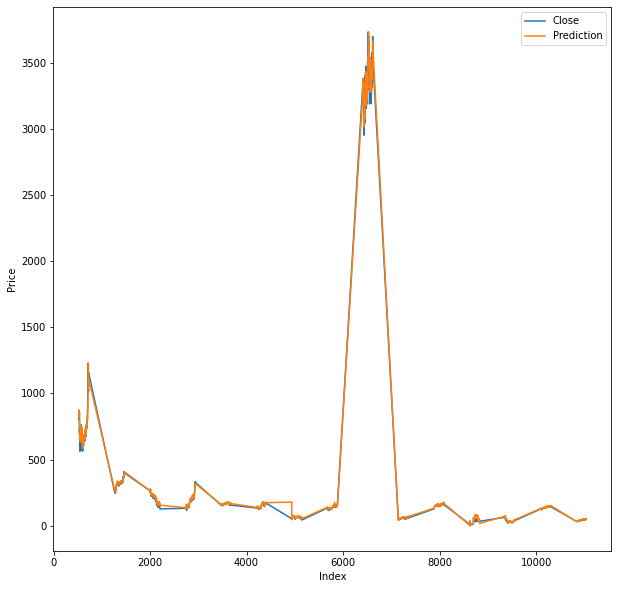

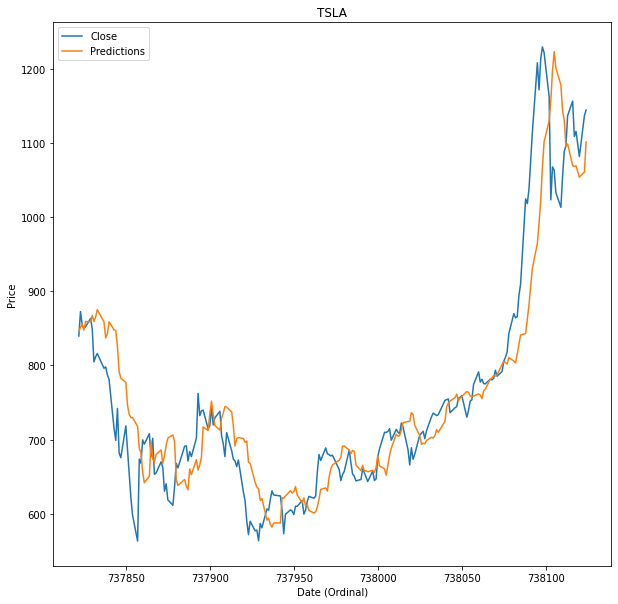

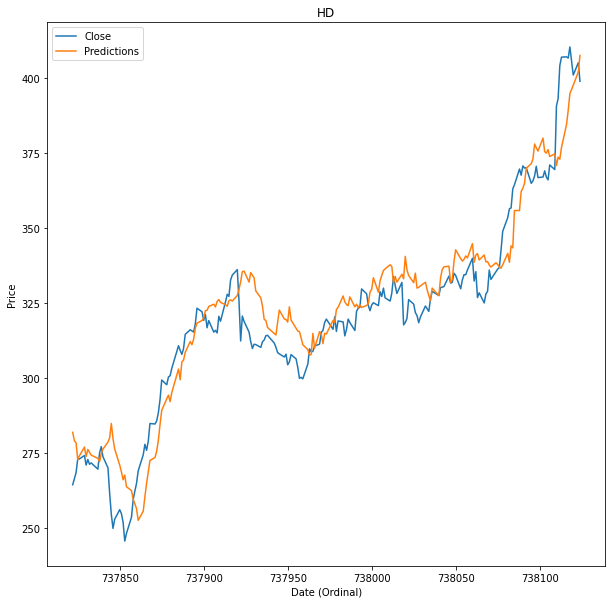

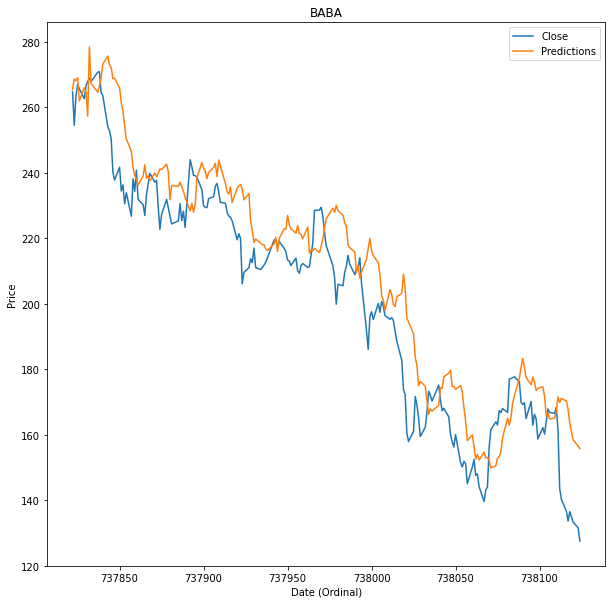

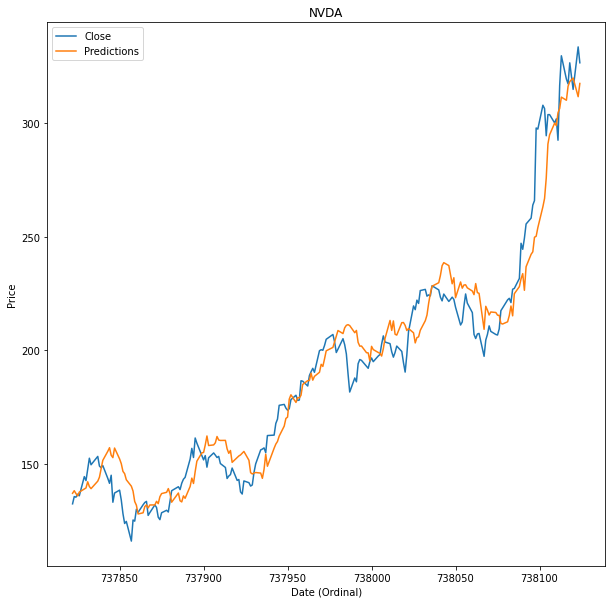

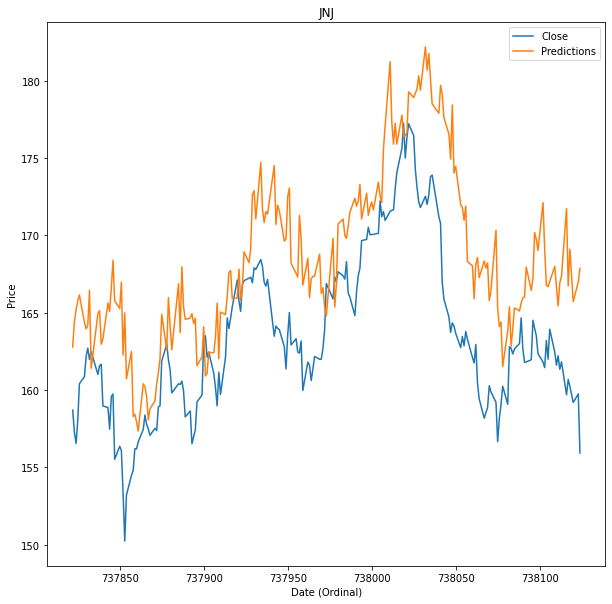

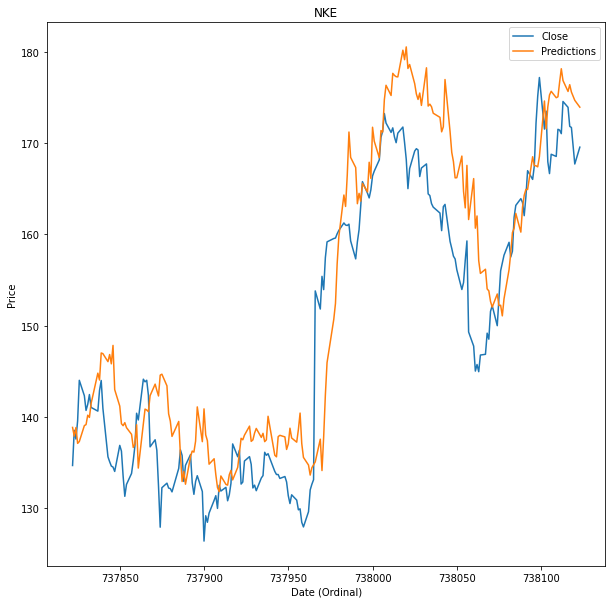

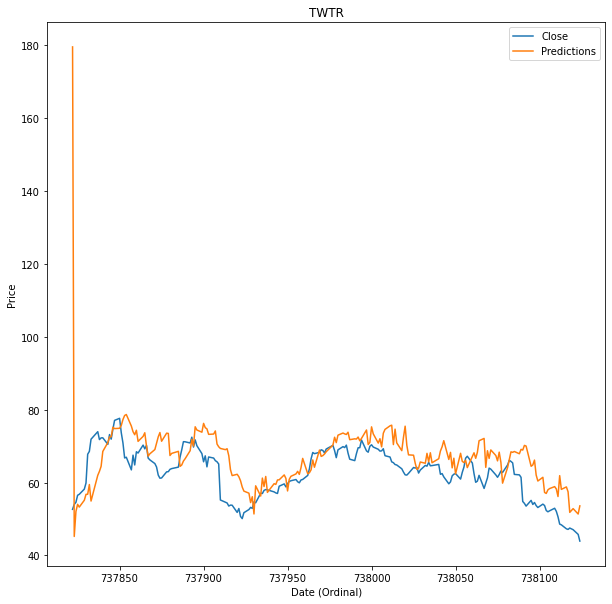

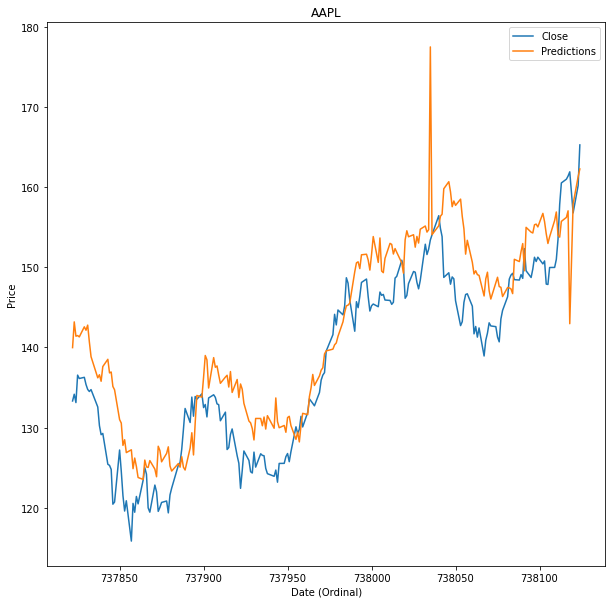

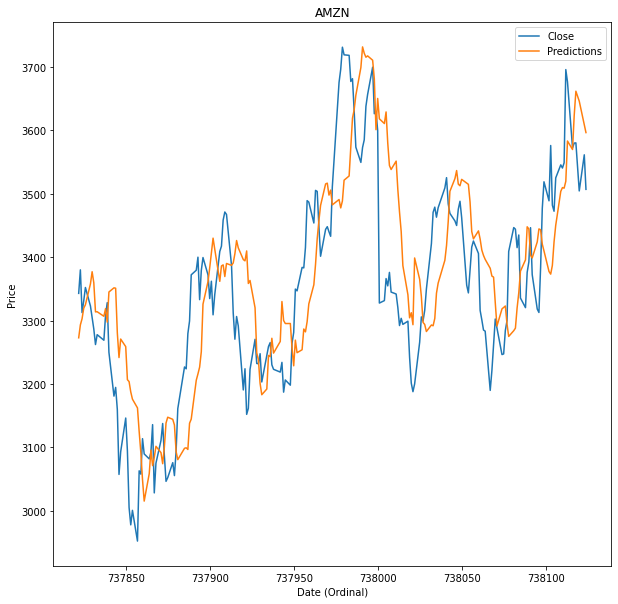

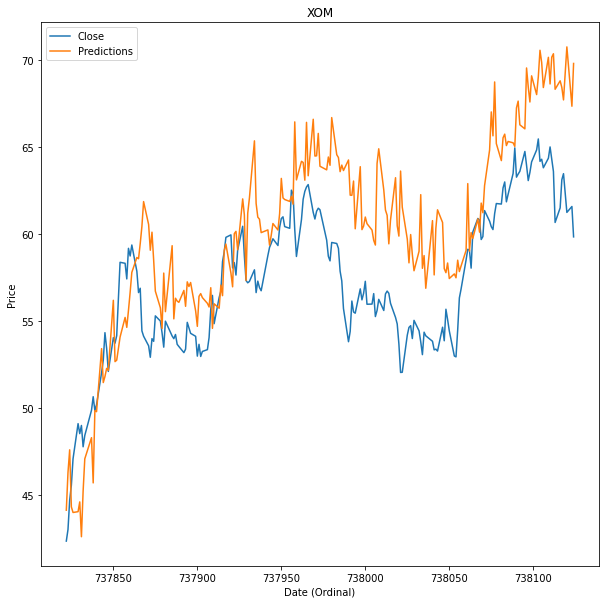

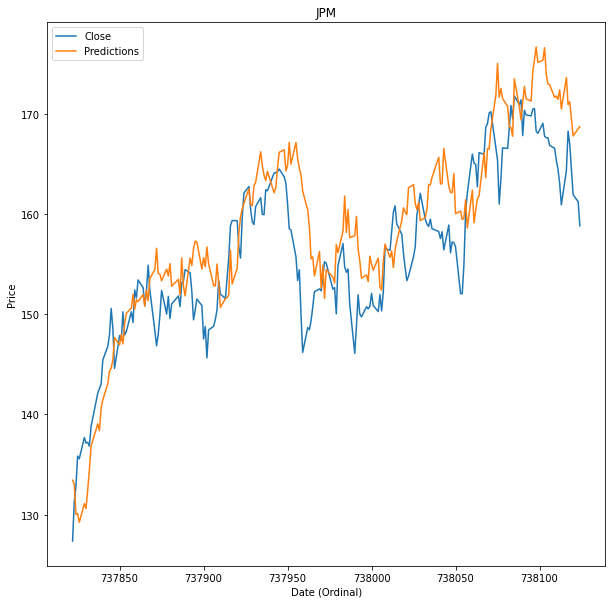

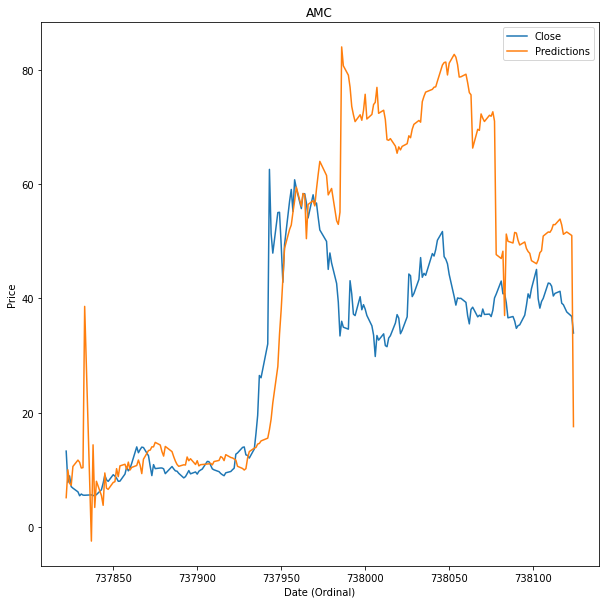

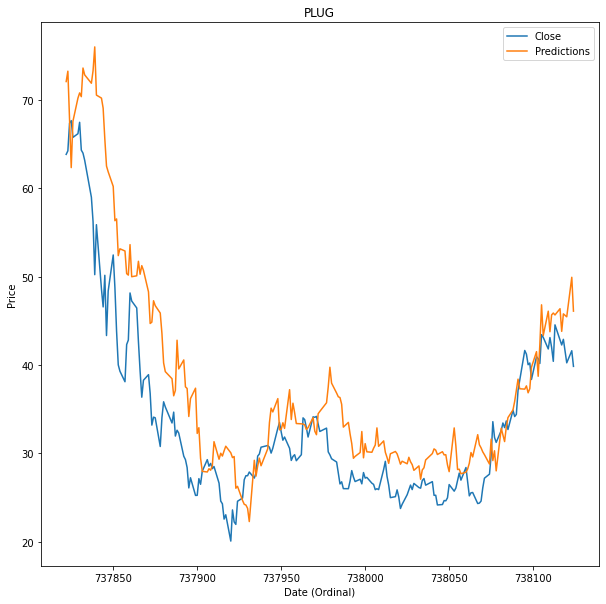

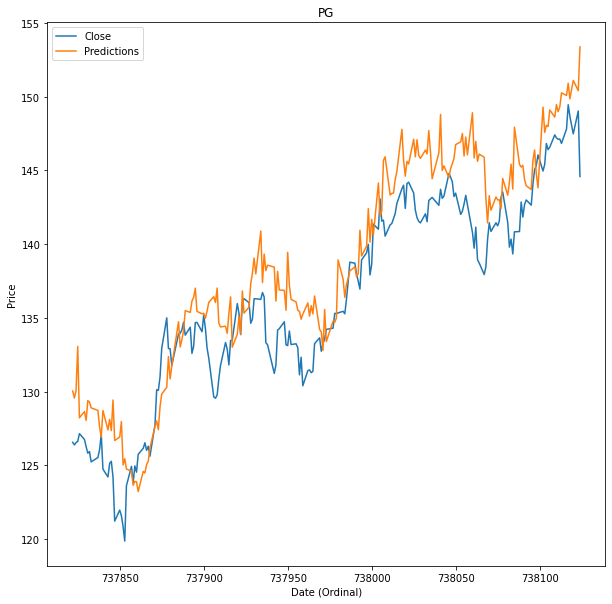

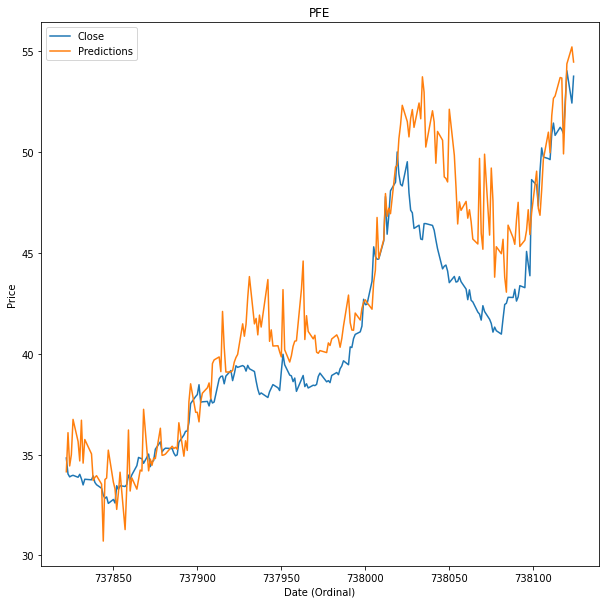

In [395]:
# Graphical Analysis

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(test['Close'], label='Close')
plt.plot(test['Predictions'], label='Prediction')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
#plt.savefig(f'results/linearRegression/{select_lag}/marketFit_reg_{select_lag}.png', bbox_inches='tight')
plt.show()

#----------------------

stockMapping = {v[0]:k for k, v in stocks.items()}
test['Stock'] = test['Stock_Num'].apply(lambda x: stockMapping[x])

for num, df_grp in test.groupby('Stock_Num'):
    plt.plot(df_grp['Date'], df_grp['Close'], label='Close')
    plt.plot(df_grp['Date'], df_grp['Predictions'], label='Predictions')
    plt.xlabel('Date (Ordinal)')
    plt.ylabel('Price')
    plt.legend()
    plt.title(stockMapping[num])
    #plt.savefig(f'results/linearRegression/{select_lag}/{stockMapping[num]}_reg_{select_lag}.png', bbox_inches='tight')
    plt.show()


In [396]:
# Error Analysis

r2_train = r2_score(y_true=y_train, y_pred=pred_train)
r2_test  = r2_score(y_true=y_test, y_pred=pred_test)

rms_train =  np.sqrt(np.mean(np.power((np.array(y_train)-np.array(pred_train)),2)))
rms_test  =  np.sqrt(np.mean(np.power((np.array(y_test)-np.array(pred_test)),2)))

mape_train = mean_absolute_percentage_error(y_true=y_train, y_pred=pred_train)
mape_test  = mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test)

metrics_dict = {
    "Metric": ["R-Square", "RMSE", "MAPE"],
    "Train": [r2_train, rms_train, mape_train],
    "Test": [r2_test, rms_test, mape_test]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv(f'results/linearRegression/{select_lag}/metrics_reg_{select_lag}.csv')
metrics_df


,Metric,Train,Test
0,R-Square,0.997922,0.998154
1,RMSE,26.316142,34.927679
2,MAPE,0.072225,0.082494


# Random Forest Decision Trees

In [387]:
# Data Prep (Random Forest)

select_lag = 7
df = pd.read_csv(f'ml_dataset_{select_lag}.csv')

df['Stock_Num'] = df['Stock'].apply(lambda x: stocks[x][0])
df.drop(columns=['Stock'], inplace=True)

df['Date'] = pd.to_datetime(df['Date'])  
date_series = df['Date']
df['Date']=df['Date'].map(datetime.datetime.toordinal)

df.sort_values(['Stock_Num', 'Date'], inplace=True, ignore_index=True)

#----------------------

train_start = datetime.datetime.strptime('2019-02-01', '%Y-%m-%d').toordinal()
train_end = datetime.datetime.strptime('2021-01-31', '%Y-%m-%d').toordinal()

test_start = datetime.datetime.strptime('2021-02-01', '%Y-%m-%d').toordinal()
test_end = datetime.datetime.strptime('2021-11-30', '%Y-%m-%d').toordinal()

train = df.loc[(df.Date >= train_start) & (df.Date <= train_end)].copy(deep=True)
test = df.loc[(df.Date >= test_start) & (df.Date <= test_end)].copy(deep=True)

x_train = train.drop(['Close', 'Date'], axis=1)
y_train = train['Close']

x_test = test.drop(['Close', 'Date'], axis=1)
y_test = test['Close']

features = list(x_train.columns.values)

#----------------------

def show_tree(estimator, max_depth=10, **kwargs):

    tree = export_text(estimator.estimators_[0], max_depth=max_depth, feature_names=features, **kwargs)
    print(tree)


In [388]:
# Predict (Decision Tree)

model_args = {
    'n_estimators': 500,
    'max_depth': 35
}

randomForest = RandomForestRegressor(**model_args)
randomForest.fit(X=x_train, y=y_train)

pred_train = randomForest.predict(x_train)
pred_test = randomForest.predict(x_test)
test['Predictions'] = pred_test


In [ ]:
show_tree(randomForest)


In [ ]:
# Graphical Analysis

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(test['Close'], label='Close')
plt.plot(test['Predictions'], label='Prediction')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
#plt.savefig(f'results/randomForest/{select_lag}/marketFit_rf_{select_lag}.png', bbox_inches='tight')
plt.show()
#----------------------

stockMapping = {v[0]:k for k,v in stocks.items()}
test['Stock'] = test['Stock_Num'].apply(lambda x: stockMapping[x])

for num, df_grp in test.groupby('Stock_Num'):
    plt.plot(df_grp['Date'], df_grp['Close'], label='Close')
    plt.plot(df_grp['Date'], df_grp['Predictions'], label='Predictions')
    plt.xlabel('Date (Ordinal)')
    plt.ylabel('Price')
    plt.legend()
    plt.title(stockMapping[num])
    #plt.savefig(f'results/randomForest/{select_lag}/{stockMapping[num]}_rf_{select_lag}.png', bbox_inches='tight')
    plt.show()


In [ ]:
# Error Analysis

r2_train = r2_score(y_true=y_train, y_pred=pred_train)
r2_test  = r2_score(y_true=y_test, y_pred=pred_test)

rms_train =  np.sqrt(np.mean(np.power((np.array(y_train)-np.array(pred_train)),2)))
rms_test  =  np.sqrt(np.mean(np.power((np.array(y_test)-np.array(pred_test)),2)))

mape_train = mean_absolute_percentage_error(y_true=y_train, y_pred=pred_train)
mape_test  = mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test)

metrics_dict = {
    "Metric": ["R-Square", "RMSE", "MAPE"],
    "Train": [r2_train, rms_train, mape_train],
    "Test": [r2_test, rms_test, mape_test]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv(f'results/randomForest/{select_lag}/metrics_rf_{select_lag}.csv')
metrics_df
